In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from collections import defaultdict

In [3]:
def load_and_preprocess(fname):
    gray = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    blurred_cropped = blurred[600:, :]
    (T, threshinv) = cv2.threshold(blurred_cropped, 200, 255, cv2.THRESH_BINARY_INV)
    return threshinv

In [4]:
def slope_close_to(theta, theta_0, tol=5):
    # theta - rad
    # theta_0 - deg
    # tol - deg
    # deg angles range from [-90,90], theta is converted to this scale
    theta_1 = (180/np.pi)*theta.copy()
    theta_1[theta_1>90] = theta_1[theta_1>90]-180
    return np.isclose(theta_1, theta_0, atol=tol)

In [244]:
def merge_lines(lines, min_gap=10):
    # lines: nx2 matrix, first column is ro and second column is theta
    # parallel lines
    # keeps the left most line
    # returns a mask that works on sorted lines on ro

    sorted_ros = lines[:, 0]

    mask = np.zeros(lines.shape[0], dtype=np.bool8)

    if len(lines) == 0:
        return mask

    mask[0] = True
    prev_ro = sorted_ros[0]
    prev_i = 0

    for i, ro in enumerate(sorted_ros[1:], start=1):
        gap = abs(ro-prev_ro)
        if gap > min_gap:
            # print(prev_i, i, prev_ro, ro, gap)
            mask[prev_i] = True
            mask[i] = True
        prev_ro, prev_i = ro, i

    mask[i] = True  # last line
    return mask

In [246]:
def get_vertical_lines(img):
    lines = np.abs(cv2.HoughLines(img,1/4,np.pi/(4*180),300).squeeze())
    sorted_lines = lines[np.argsort(lines[:,0])]
    vertical_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 0, tol=15)]
    vertical_lines_merged = vertical_lines[merge_lines(vertical_lines, min_gap=10)]
    return vertical_lines_merged

In [267]:
def patches(img, vertical_lines, stack, sub_stack, col=None):
    y1,y2 = 0,img.shape[0]
    
    if sub_stack == 0:
        x1= 0 if stack==0 else int(vertical_lines[12*stack-1,0])
        x2=int(vertical_lines[12*stack,0])
    elif sub_stack == 1:
        x1=int(vertical_lines[12*stack,0])
        x2=int(vertical_lines[12*stack+2,0])
    else:
        if col is None:
            x1=int(vertical_lines[12*stack+2,0])
            x2=int(vertical_lines[12*stack+11,0])
        else:
            x1=int(vertical_lines[12*stack+2+2*col,0])
            x2=int(vertical_lines[12*stack+2+2*col+1,0])
    
    # print(x1,x2,y1,y2)
    return img[y1:y2, x1:x2]

In [9]:
def connected_components(data):
    labels = np.zeros_like(data).astype(np.uint64)
    n = 0
    for i in range(len(data[1:])):
        left = data[i-1]
        if data[i] != 0:
            if left == 0:
                n += 1
                labels[i] = n
            else:
                labels[i] = n
            
    return labels

In [92]:
def segment(p, min_width=25, min_intensity=180):
    data = np.sum(p, axis=1)/p.shape[1]
    data_thresh = data.copy()
    data_thresh[data_thresh<20] = 0
    cc = connected_components(data_thresh)
    
    # remove components with width less than min_width
    labels = set(np.unique(cc))-{0}
    for c in labels:
        if cc[cc==c].shape[0] < 20:
            cc[cc==c] = 0
            
    labels = set(np.unique(cc))-{0}
    
    # calculate average intensity of each component
    avg_intensity = np.zeros(len(labels))
    for i,c in enumerate(labels):
        avg_intensity[i] = np.mean(data_thresh[cc==c])
    
    # map components with intensity less than min_intensity as 0 (unfilled) otherwise 1 (filled)
    return [1 if i > min_intensity else 0 for i in avg_intensity], cc
    

In [219]:
def wreck_it(gray, theta=-0.5, scale=1.1, sigma=5):
    h,w = gray.shape
    M = cv2.getRotationMatrix2D((w/2, h/2), theta, scale)
    shifted = cv2.warpAffine(gray, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    noisy = np.clip(shifted.astype(np.uint64) + sigma*np.random.randn(h,w), a_min=0, a_max=255).astype(np.uint8)
    return noisy

In [83]:
img = load_and_preprocess('../test-images/a-30.jpg')
vertical_lines = get_vertical_lines(img)

In [313]:
answers = defaultdict(list)
for stack in [0,1,2]:
    for col in [0,1,2,3,4]:
        p = patches(img, vertical_lines, stack=stack, sub_stack=2, col=col)
        qnum_start = 29*stack
        filled, cc = segment(p, min_width=25, min_intensity=180)
        print(stack, col, len(filled))
        for i,f in enumerate(filled):
            if f==1:
                q_num = qnum_start + i + 1
                answers[q_num].append(col)
                
written = {}
for stack in [0,1,2]:
    p = patches(img, vertical_lines, stack=stack, sub_stack=0)
    qnum_start = 29*stack
    options_col_p = patches(img, vertical_lines, stack=stack, sub_stack=2, col=0)
    filled, cc = segment(options_col_p, min_width=25, min_intensity=180)
    
    for i,c in enumerate(set(np.unique(cc))-{0}):
        s=np.nonzero(cc==c)[0]
        avg_intensity = np.mean(p[s[0]-9:s[-1]+9,5:-5])
        q_num = qnum_start + i + 1
        written[q_num] = avg_intensity > 4

0 0 29
0 1 29
0 2 29
0 3 29
0 4 29
1 0 29
1 1 29
1 2 29
1 3 29
1 4 29
2 0 27
2 1 27
2 2 27
2 3 27
2 4 27


In [314]:
answers_str = [f'{i} {"".join([chr(ord("A")+a) for a in anss])}{" x" if written[i] else ""}' for i, anss in sorted(answers.items())]

In [315]:
with open('a-30_results.txt', 'w') as f:
    f.write('\n'.join(answers_str))

In [320]:
p = patches(img, vertical_lines, stack=2, sub_stack=2, col=3)

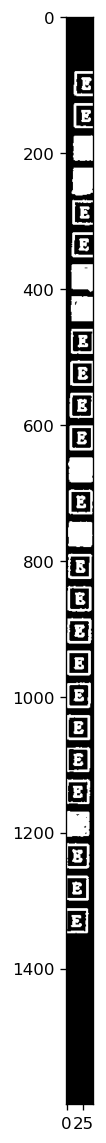

In [321]:
plt.figure(figsize=(10, 12))
plt.imshow(p, cmap='gray')

In [210]:
filled, cc = segment(patches(img, vertical_lines, stack=1, sub_stack=2, col=0), min_width=25, min_intensity=180)

In [213]:
np.mean(p[s[0]-9:s[-1]+9,5:-5])

3.0357142857142856

In [ ]:
plt.imshow(p[s[0]-9:s[-1]+9,:], cmap='gray')

In [211]:
s=np.nonzero(cc==1)[0]

In [190]:
s[0]

1357

In [238]:
def show_lines(img, lines, title='img'):
    fig, axes = plt.subplots(figsize=(10,16))
    axes.imshow(img, cmap='gray')
    d = max(img.shape)
    for rho,theta in lines:
        dx = np.cos(theta)
        dy = np.sin(theta)
        x0 = dx*rho
        y0 = dy*rho
        # (x0,y0) is a point on the line
        # print(x0,y0)
        x1 = int(x0 + d*(-dy))
        y1 = int(y0 + d*(dx))
        x2 = int(x0 - d*(-dy))
        y2 = int(y0 - d*(dx))
        # print(x1,y1,x2,y2)
        axes.plot([x1,x2], [y1,y2], '-.', color='red', alpha=0.7)
    axes.set_xlim(0, img.shape[1]) # x is cols
    axes.set_ylim(img.shape[0], 0) # y is rows
    axes.set_title(title)

In [284]:
gray = cv2.imread('../test-images/a-30.jpg', cv2.IMREAD_GRAYSCALE)

In [459]:
im = wreck_it(gray, theta=0, scale=1, sigma=0)

In [460]:
ROI_Y_RATIO = 600/2200
BINARY_THRESHOLD = 200

blurred = cv2.GaussianBlur(im, (5, 5), 0)
blurred_cropped = blurred[int(ROI_Y_RATIO*im.shape[0]):, :]
(T, threshinv) = cv2.threshold(blurred_cropped, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
img = threshinv

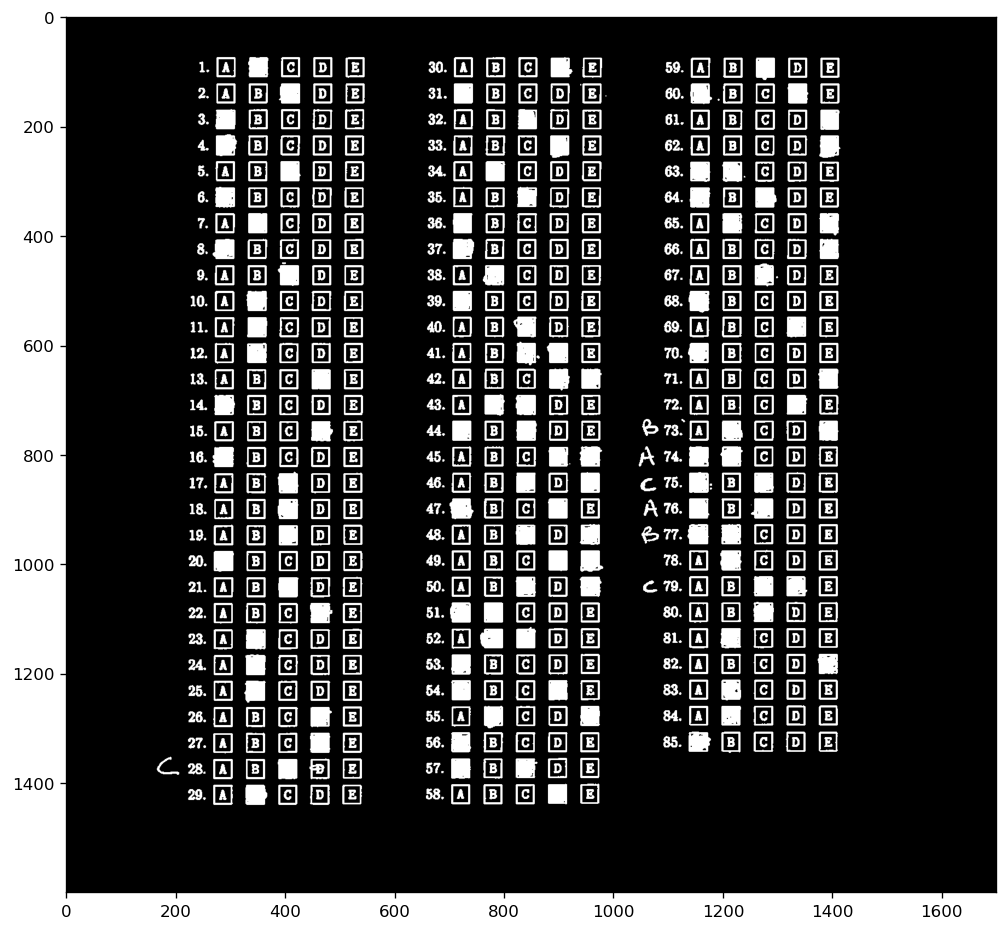

In [461]:
plt.figure(figsize=(10, 12))
plt.imshow(threshinv, cmap='gray')

(array([32.,  0., 57.,  0., 60.,  0., 58.,  0.,  0., 44.,  0., 26.,  0.,
        11.,  0.,  0.,  9.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.]),
 array([0.        , 0.02708333, 0.05416667, 0.08125   , 0.10833333,
        0.13541667, 0.1625    , 0.18958333, 0.21666667, 0.24375   ,
        0.27083334, 0.29791668, 0.325     , 0.35208333, 0.37916666,
        0.40625   , 0.43333334, 0.46041667, 0.4875    , 0.51458335,
        0.5416667 , 0.56875   , 0.59583336, 0.62291664, 0.65      ,
        0.6770833 , 0.70416665, 0.73125   , 0.7583333 , 0.78541666,
        0.8125    ], dtype=float32),
 <BarContainer object of 30 artists>)

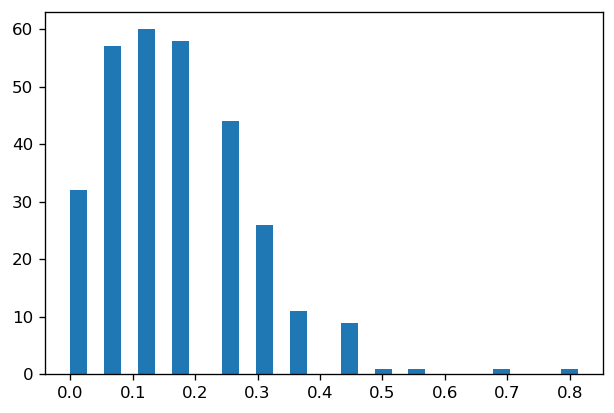

In [464]:
theta = (180/np.pi)*lines[:,1]
theta[theta > 90] = 180-theta[theta > 90]
plt.hist(theta, bins=30)

In [465]:
lines.shape, vertical_lines.shape, vertical_lines_merged.shape

((301, 2), (301, 2), (66, 2))

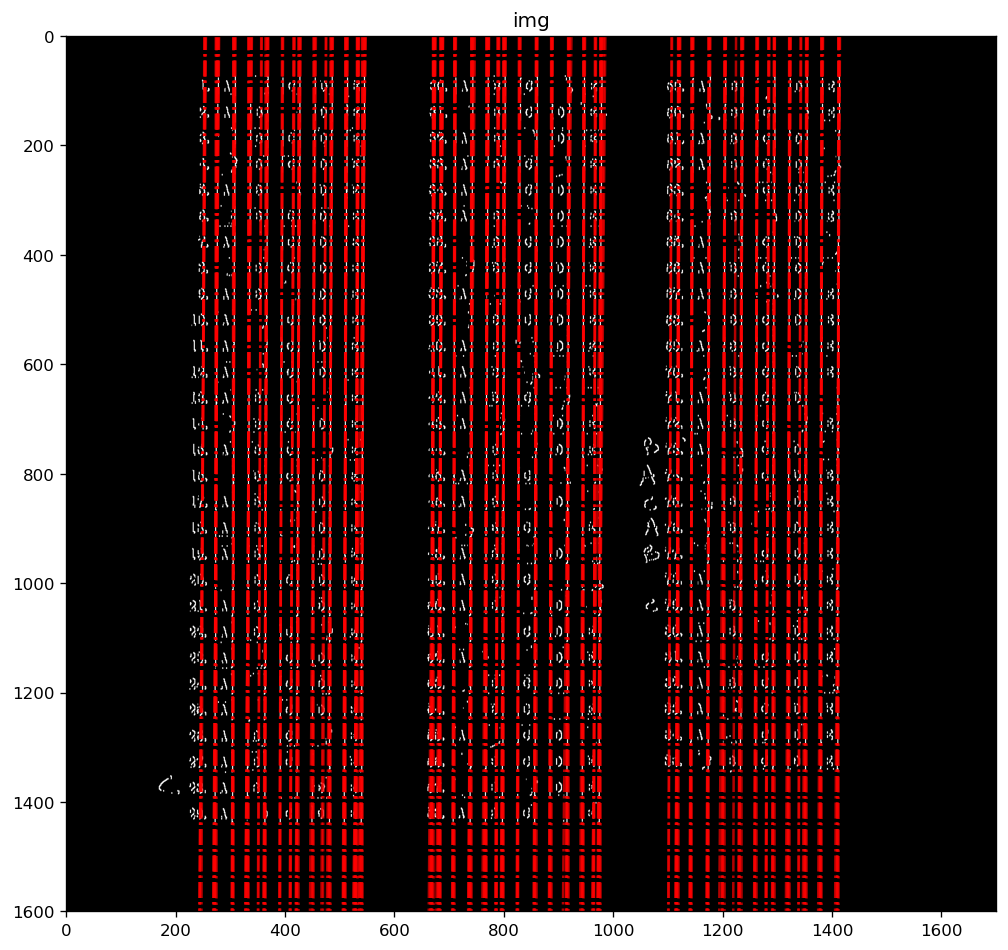

In [463]:
# vertical_lines = get_vertical_lines(img)
lines = np.abs(cv2.HoughLines(pf,1, np.pi/(16*180),300).squeeze())
sorted_lines = lines[np.argsort(lines[:,0])]
vertical_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 0, tol=5)]
vertical_lines_merged = vertical_lines[merge_lines(vertical_lines, min_gap=10)]
show_lines(pf, vertical_lines)

In [266]:
vertical_lines.shape

(36, 2)

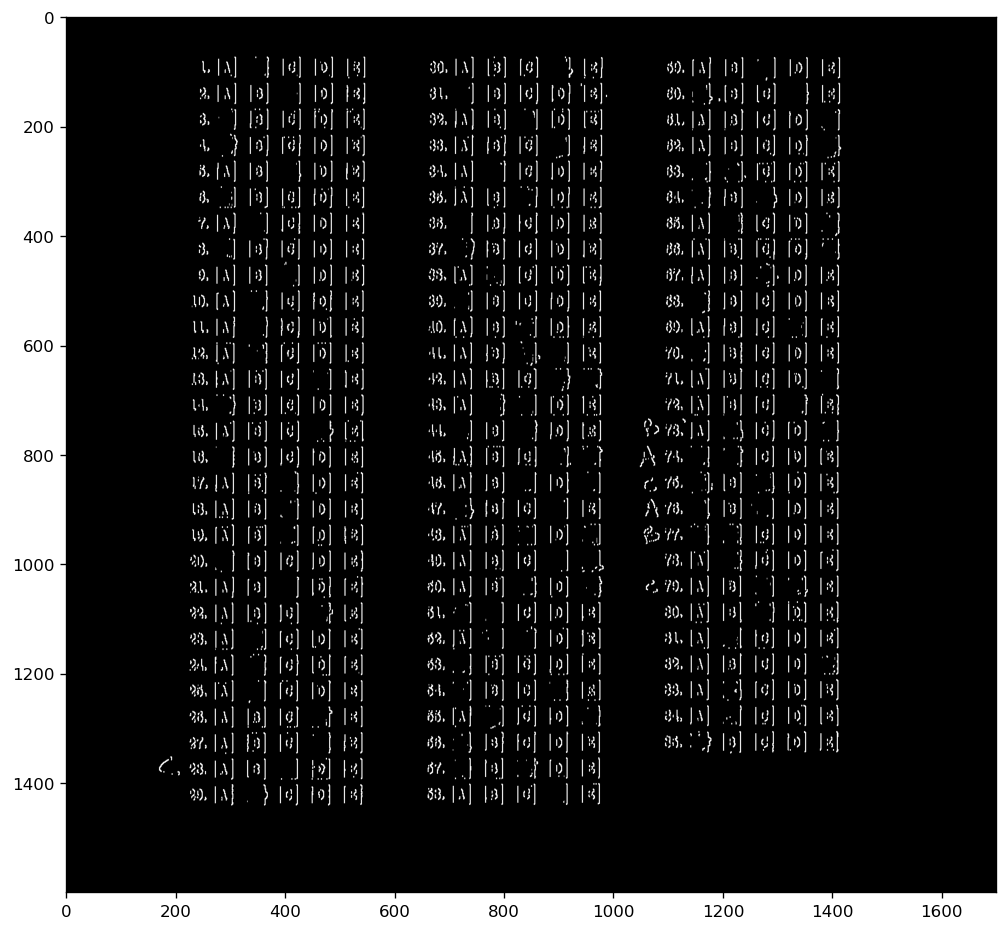

In [462]:
plt.figure(figsize=(10,12))
kernel1 = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).T
# kernel1 = kernel1/np.sum(kernel1)
pf = cv2.filter2D(src=img, ddepth=-1, kernel=kernel1)
plt.imshow(pf, cmap='gray')